In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from ics.hxutils import hxramp
from h4rg_analysis import io, ramputils
import makefigures_noise

In [3]:
tfilename = './tempcorr'

In [4]:
bestbaselines = open ('../data/paths/best_ever_baseline_darks_8_21_2022.txt', 'r').read().splitlines()[1:]

In [5]:
pt = io.jhu2tiger(bestbaselines[0])

In [6]:
rampids = makefigures_noise.load_rampids ()

In [7]:
ramp = hxramp.HxRamp(pt)

In [8]:
nbins = 10
step = ramp.ncols // nbins
sl_indices = np.concatenate ( [np.arange(0, ramp.ncols, step)[:-1], [ramp.ncols+1]] )
slices = [ slice(sl_indices[idx], sl_indices[idx+1]) for idx in range(sl_indices.size-1) ]

In [16]:
ns = np.arange(10,101,5)
def preproc ( dtype ):
    if dtype == 'data':
        fn = io.dataStack_memmap
        dlabel = 'data'
    elif dtype == 'corr':
        fn = io.corrStack_memmap
        dlabel = 'data - IRP'
    elif dtype == 'IRP':
        fn = io.irpStack_memmap
        dlable = 'IRP'

    cube,_ = fn ( ramp, r1=99, filename=tfilename, slicey=slices[0], slicex=slices[1] )
    
    rhat_se_arr = np.zeros([ns.size, 2, cube.shape[1], cube.shape[2]])
    for idx,cnread in enumerate(ns):
        _,rhat,rhat_se = ramputils.utr_expectedflux ( cube[:cnread].astype(float) )
        rhat_se_arr[idx,0] = rhat_se[0]
        rhat_se_arr[idx,1] = rhat_se[1]
    
    del cube
    return rhat_se, rhat_se_arr

In [26]:
dtypes = ['data', 'IRP', 'corr']
dlabels = ['data', 'IRP', 'data - IRP']

In [18]:
ll = []
for dtype in dtypes:
    out = preproc ( dtype )
    ll.append(out)

46.61967251668089
42.87152622200471


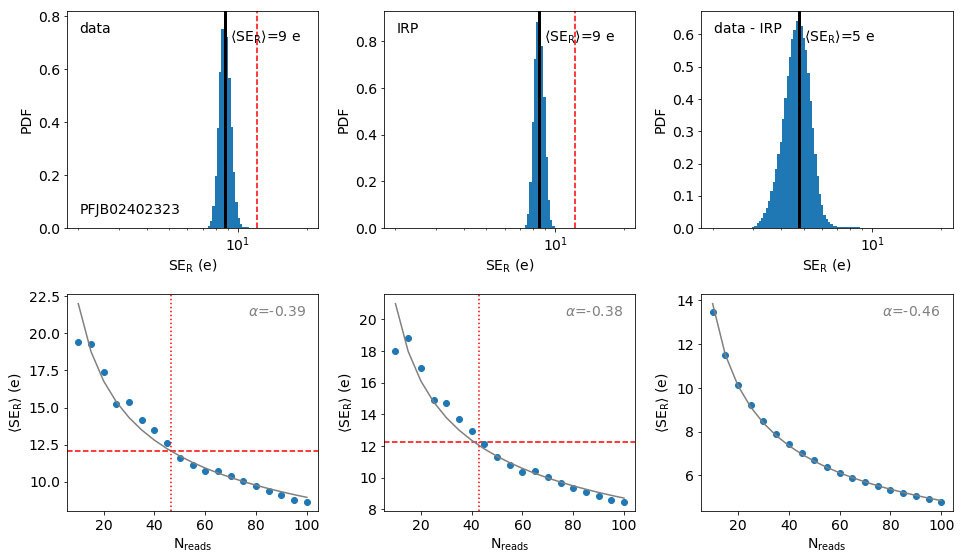

In [39]:
fsize=4
fig, axarr = plt.subplots(2,3,figsize=(fsize*3.4, fsize*2))
bins = np.logspace(np.log10(2),np.log10(20.),100)
    
teledyne_num = [12.05, 12.25]
for jdx in range(len(ll)):
    rhat_se, rhat_se_arr = ll[jdx]
    dtype = dlabels[jdx]
    securve = np.median(np.median(rhat_se_arr[:,0],axis=1),axis=1)*makefigures_noise.gain
    pfit = np.polyfit ( np.log10(ns), np.log10(securve), 1)

    # \\ SE
    ax = axarr[0,jdx]
    out = ax.hist(rhat_se[0].flatten()*makefigures_noise.gain, bins=bins, density=True, )
    med_sea = np.median(rhat_se[0].flatten()*makefigures_noise.gain)
    ax.axvline ( med_sea, color='k', lw=3 )
    ax.annotate ( r'$\langle \rm SE_{\rm R}\rangle$=%.0f e' % med_sea, (med_sea*1.05, out[0].max()*.9), color='k' )
    ax.set_xscale('log')
    #ax.set_title(f'''{dlabel} UTR estimator uncertainty''' )
    if jdx == 0:
        ax.text ( 0.05, 0.05, rampids[0],  ha='left', va='bottom', transform=ax.transAxes )
    if jdx < 2:
        ax.axvline ( teledyne_num[jdx], color='r', ls='--', zorder=0)
    ax.text ( 0.05, 0.95, dtype, ha='left', va='top', transform=ax.transAxes)
    ax.set_xlabel(r'SE$_{\rm R}$ (e)')
    ax.set_ylabel('PDF')

    # \\ SE vs. Nread
    ax = axarr[1,jdx]
    ax.plot(ns, securve, 'o')
    ax.plot(ns, 10.**np.poly1d(pfit)(np.log10(ns)), color='grey')
    ax.set_xlabel(r'N$_{\rm reads}$')
    ax.set_ylabel(r'$\langle \rm SE_R \rangle$ (e)')
    ax.text ( 0.95, 0.95, fr'$\alpha$={pfit[0]:.2f}', ha='right', va='top', 
                     color='grey',
                     transform=ax.transAxes )
    if jdx < 2:
        ax.axhline ( teledyne_num[jdx], color='r', ls='--', zorder=0)
        match = 10.**np.poly1d(np.polyfit(np.log10(securve), np.log10(ns), 1))(np.log10(12.05))
        ax.axvline ( match, color='r', ls=':' )
        print(match)

plt.tight_layout ()
plt.savefig(f'../figures/SER_{rampids[0]}.png')

In [40]:
19.26 * makefigures_noise.gain

61.632000000000005

In [26]:
xs = np.arange(cube.shape[0])
ypred = xs[:,np.newaxis,np.newaxis]*rhat[0] + rhat[1]
rmse = np.sqrt ( np.sum((ypred - cube)**2,axis=0)/cube.shape[0] )

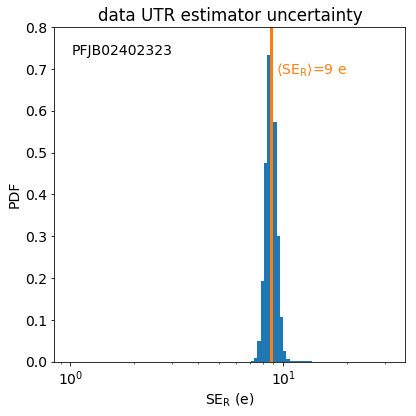

In [17]:
fig = plt.figure ()
ax = plt.subplot(111)

plt.tight_layout ()
plt.savefig(f'../figures/{rampids[0]}_{dtype}-SER.png')

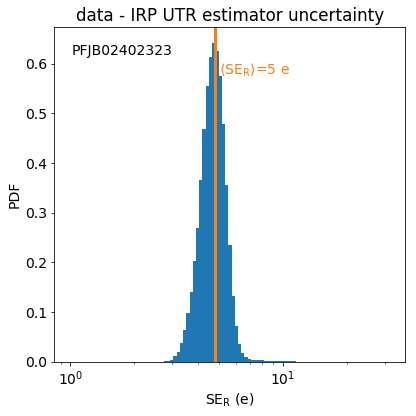

In [222]:
fig = plt.figure ()
ax = plt.subplot(111)
out = plt.hist(rhat_se[0].flatten()*makefigures_noise.gain, bins=np.logspace(0,1.5,100), density=True)
med_sea = np.median(rhat_se[0].flatten()*makefigures_noise.gain)
ax.axvline ( med_sea, color='C1', lw=3 )
ax.annotate ( r'$\langle \rm SE_{\rm R}\rangle$=%.0f e' % med_sea, (med_sea*1.05, out[0].max()*.9), color='C1' )
ax.set_xscale('log')
ax.set_title(f'''data - IRP UTR estimator uncertainty''' )
ax.text ( 0.05, 0.95, rampids[0],  ha='left', va='top', transform=ax.transAxes )
ax.set_xlabel(r'SE$_{\rm R}$ (e)')
ax.set_ylabel('PDF')
plt.tight_layout ()
plt.savefig(f'../figures/{rampids[0]}_SER.png')